In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'], date_format='%m/%d/%y')
df.set_index('Dates', inplace=True)
df = df.asfreq('ME')

In [3]:
train_data = df[:-12]
test_data = df[-12:] 

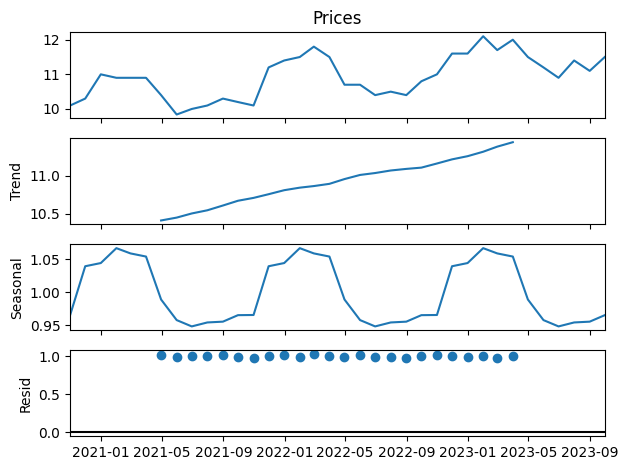

In [4]:
decomposition = sm.tsa.seasonal_decompose(train_data['Prices'], model='multiplicative')
decomposition.plot()
plt.show()

In [5]:
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

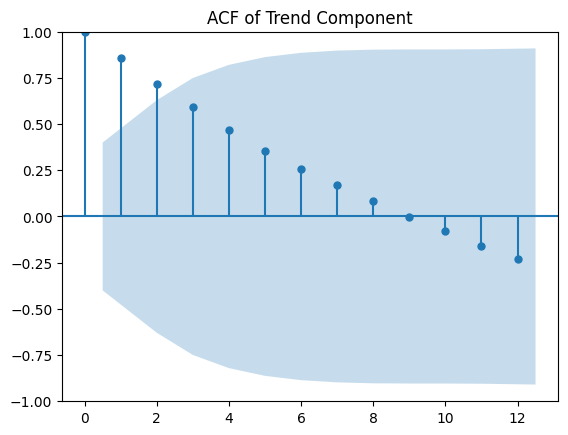

In [6]:
plot_acf(trend)
plt.title('ACF of Trend Component')
plt.show()

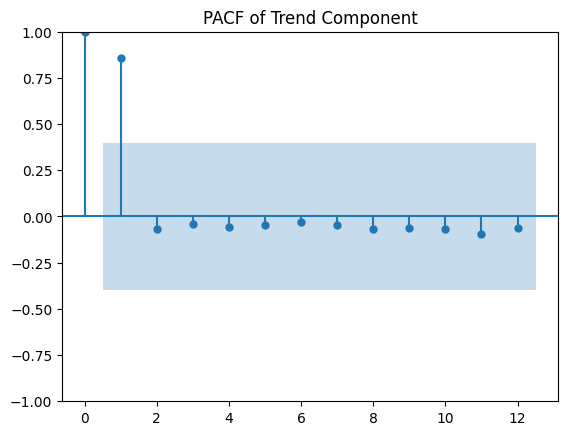

In [7]:
plot_pacf(trend)
plt.title('PACF of Trend Component')
plt.show()

In [8]:
dummy_trend = trend
dummy_trend = dummy_trend.diff()
dummy_trend = dummy_trend.diff()
dummy_trend = dummy_trend.diff()
adf_result = adfuller(dummy_trend.dropna())  
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The trend component is stationary.")
else:
    print("The trend component is not stationary, differencing may be needed.")

ADF Statistic: -3.8544851956382264
p-value: 0.0023965517545223576
The trend component is stationary.


In [9]:
arima_model = ARIMA(trend.dropna(), order=(2,2,1)) 
arima_fit = arima_model.fit()
forecast_diff = arima_fit.forecast(steps=12)
seasonality_forecast = seasonal[-12:].values
final_forecast = forecast_diff.values * seasonality_forecast

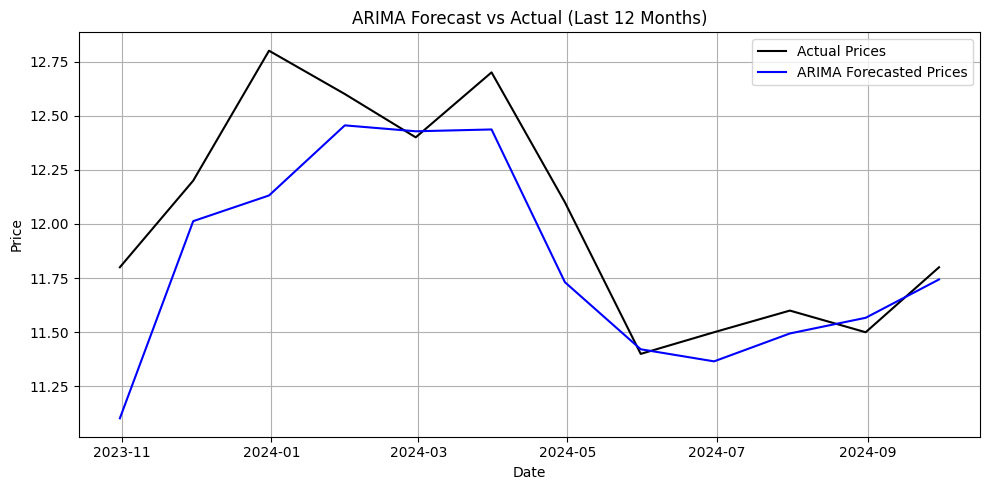

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.values, label='Actual Prices', color='black')
plt.plot(test_data.index, final_forecast, label='ARIMA Forecasted Prices', color='blue')
plt.title('ARIMA Forecast vs Actual (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:

X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X, y)
X_future = np.arange(len(trend), len(trend) + 12).reshape(-1, 1)
lr_trend_forecast = lr_model.predict(X_future)
seasonality_forecast = np.tile(seasonal[-12:].values, 1)
lr_final_forecast = lr_trend_forecast * seasonality_forecast


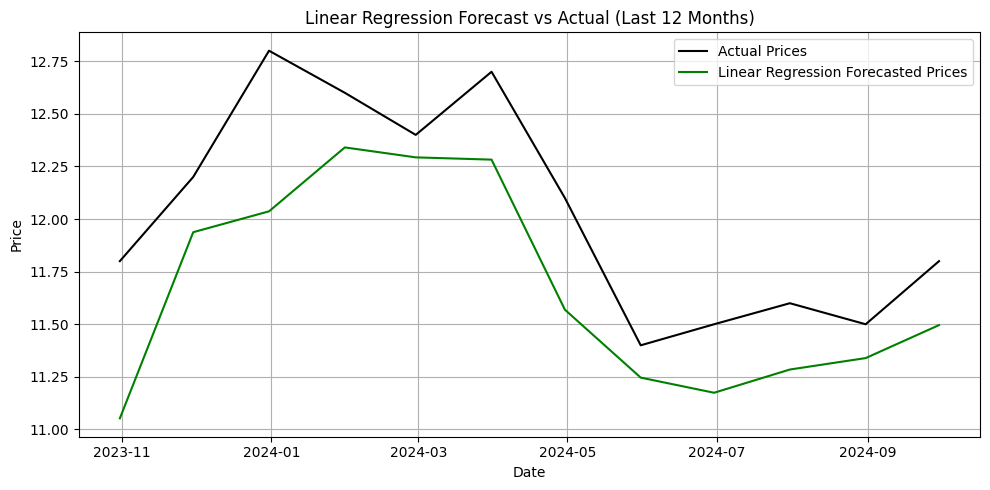

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data.values, label='Actual Prices', color='black')
plt.plot(test_data.index, lr_final_forecast, label='Linear Regression Forecasted Prices', color='green')
plt.title('Linear Regression Forecast vs Actual (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
arima_rmse = np.sqrt(mean_squared_error(test_data['Prices'], final_forecast))
print(f'ARIMA Forecast RMSE: {arima_rmse:.2f}')
lr_rmse = np.sqrt(mean_squared_error(test_data['Prices'], lr_final_forecast[:12]))
print(f'Linear Regression Forecast RMSE: {lr_rmse:.2f}')

ARIMA Forecast RMSE: 0.32
Linear Regression Forecast RMSE: 0.42


In [14]:
future_arima_forecast = arima_fit.forecast(steps=12)
future_seasonality = np.tile(seasonal[-12:].values, 1)
future_arima_prices = future_arima_forecast.values * future_seasonality

C:\Users\91816\AppData\Local\Temp\ipykernel_22384\3171285083.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')


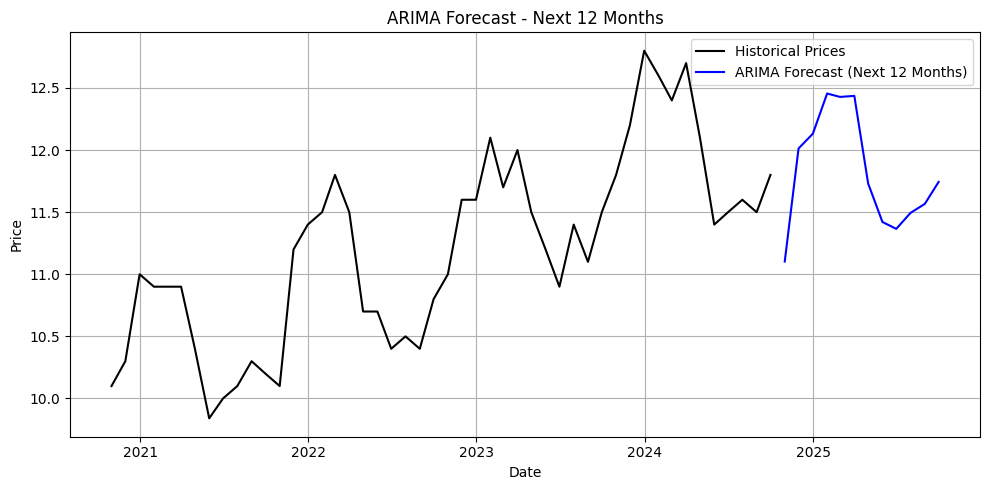

In [15]:
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Prices'], label='Historical Prices', color='black')
plt.plot(future_dates, future_arima_prices, label='ARIMA Forecast (Next 12 Months)', color='blue')
plt.title('ARIMA Forecast - Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
X_all = np.arange(len(trend)).reshape(-1, 1)
lr_model.fit(X_all, trend.values)

LinearRegression()

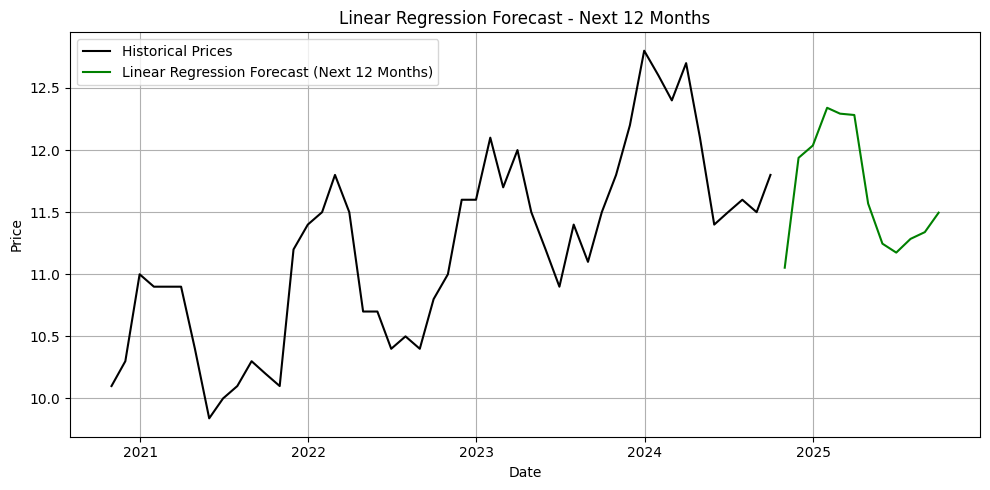

In [17]:
X_next = np.arange(len(trend), len(trend) + 12).reshape(-1, 1)
future_lr_trend = lr_model.predict(X_next)
future_lr_prices = future_lr_trend * future_seasonality

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Prices'], label='Historical Prices', color='black')
plt.plot(future_dates, future_lr_prices, label='Linear Regression Forecast (Next 12 Months)', color='green')
plt.title('Linear Regression Forecast - Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
def forecast_price(date_input, model_type):
    if not isinstance(date_input, pd.Timestamp):
        date_input = pd.to_datetime(date_input)

    last_date = df.index[-1]

    if date_input <= last_date:
        print("Date is in the past or already in dataset.")
        return df.loc[date_input, 'Prices'] if date_input in df.index else None

    months_ahead = (date_input.year - last_date.year) * 12 + (date_input.month - last_date.month)

    seasonal_values = seasonal[-12:].values
    seasonal_index = (months_ahead - 1) % 12
    seasonal_multiplier = seasonal_values[seasonal_index]

    if model_type.lower() == 'arima':
        forecast_trend = arima_fit.forecast(steps=months_ahead).values[-1]
    elif model_type.lower() == 'lr':
        X_future = np.array([[len(trend) + months_ahead - 1]])
        forecast_trend = lr_model.predict(X_future)[0]
    else:
        raise ValueError("Invalid model_type. Use 'arima' or 'lr'.")

    return forecast_trend * seasonal_multiplier


In [19]:
from datetime import datetime

price = forecast_price(datetime(2026, 1, 31), 'lr')
print(f"Forecasted price: ${price:.2f}")


Forecasted price: $12.88
